In [0]:
RETRAIN_UNET = False
RETRAIN_CNN = True

## Setup enviroment

### Imports

In [3]:
!pip3 install hiddenlayer
!pip3 install ipdb
import json
import os
import numpy as np
import random

from scipy.sparse import coo_matrix

import torch as tr
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets.folder import default_loader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from google.colab import drive
import hiddenlayer as hl

from PIL import Image, ImageDraw

tr.backends.cudnn.deterministic = False
tr.backends.cudnn.benchmark = True

  Created wheel for ipdb: filename=ipdb-0.13.2-cp36-none-any.whl size=10522 sha256=7fc9384deb94d8da3c0f62e4fa113b28108793a5e099b0ad444ca16e7c711ad5
  Stored in directory: /root/.cache/pip/wheels/60/c2/15/793365e3c9318c46ba914263740d90f1fe67f544b979141ce4
Successfully built ipdb


### Connect with drive

In [4]:
drive.mount('./drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./drive


In [0]:
os.chdir("./drive/My Drive/Workspace/LeelasEye")

## Dataset

In [0]:
IMG_SIZE = (512, 384)

class GODataset(Dataset):
    def __init__(self, out_rescale = 1/4):
        super(Dataset, self).__init__()
        self.out_rescale = out_rescale
        self.pipeline = transforms.Compose([
                                            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                            transforms.ToTensor()
                                            ])
        
    @classmethod
    def load_from_folder(cls, vertexs_file, position_file):
        ds = cls()

        with open(vertexs_file, 'r') as f:
            vertexs_file = json.load(f)
        with open(position_file, 'r') as f:
            position_file = json.load(f)

        ds.filename = [entry['data']['image'] for entry in vertexs_file]

        ds.position = {entry['file'] : np.array(entry['positions']).reshape(9,9)
                        for entry in position_file}

        ds.vertex = {entry['data']['image'] : entry['completions'][0]['result'][0]['value']['points']
                     for entry in vertexs_file}

        ds.image = {filename : default_loader("data/" + filename).resize(IMG_SIZE)
                    for filename in ds.filename}
        return ds

    def vert2array(self, vertexs):
        w, h = int(IMG_SIZE[1] * self.out_rescale), int(IMG_SIZE[0] * self.out_rescale)
        array = tr.zeros(1, w, h)
        for vert in vertexs:
            array[0, int(vert[1] * w / 100), int(vert[0] * h / 100)] = 1
        return array

    def __len__(self):
      return(len(self.filename))

    def __getitem__(self, i):
        fname = self.filename[i]
        image = self.image[fname]
        vertex_region = self.vert2array(self.vertex[fname])
        board_position = self.position[fname]
        return self.pipeline(image), vertex_region, board_position

    
dataset = GODataset.load_from_folder("labeled-boards_fixed.json", "positions.json")

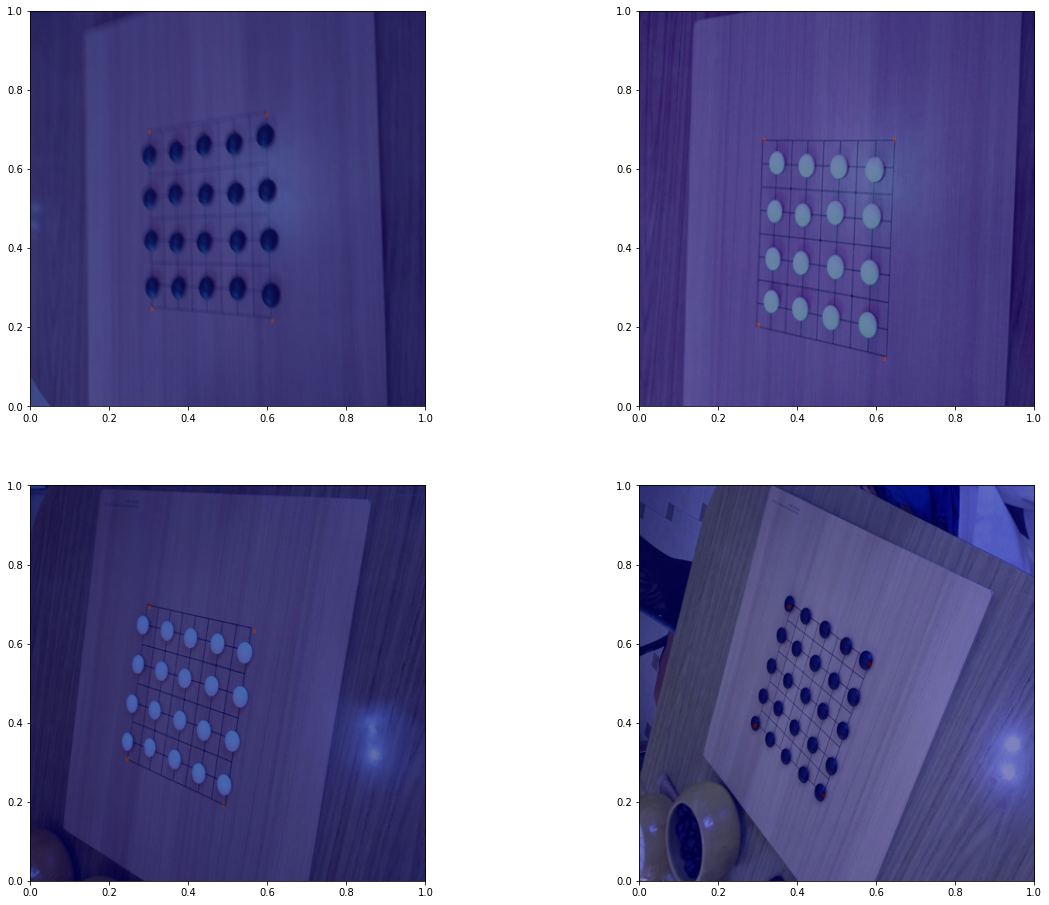

In [7]:
extent = (0, 1, 0, 1)
plt.figure(figsize=(20,16))
for i in range(4):
    plt.subplot(2, 2, i+1)
    index = random.randrange(len(dataset))
    plt.imshow(dataset[index][0].permute(1,2,0), extent=extent)
    plt.imshow(dataset[index][1][0], cmap='jet', extent=extent, alpha=0.5)
plt.show()

## UNET vertex segmenter

### Model

In [0]:
def conv_block(in_dim, out_dim):
    return nn.Sequential(nn.Conv2d(in_dim, out_dim, kernel_size=[3,3], padding=[1,1]),
                         nn.ELU(),
                         nn.BatchNorm2d(out_dim))
    

class UNET(nn.Module):
    def __init__(self, prelayers, unet_levels):
        super(UNET, self).__init__()
        self.downscale = nn.AvgPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.pre_cnn = nn.ModuleList()
        self.in_cnn = nn.ModuleList()
        self.out_cnn = nn.ModuleList()
        
        for i in range(prelayers):
            self.pre_cnn.append(nn.Sequential(conv_block(3 if i == 0 else 8, 8), nn.MaxPool2d(2)))

        for i in range(unet_levels):
            self.in_cnn.append(conv_block(8, 8))
        self.bottom_cnn = conv_block(8, 8)

        for i in range(unet_levels):
            self.out_cnn.append(conv_block(16, 8))
        self.last_cnn = nn.Sequential(nn.Conv2d(8, 1, kernel_size=[3,3], padding=[1,1]),
                                      nn.Sigmoid())
        
        self.to_tensor = transforms.ToTensor()

    def forward(self, x):
        for i in range(len(self.pre_cnn)):
            x = self.pre_cnn[i](x)
        mid = []
        for i in range(len(self.in_cnn)):
            x = self.in_cnn[i](x)
            mid.append(x)
            x = self.downscale(x)
        x = self.bottom_cnn(x)
        for i in range(len(self.out_cnn)):
            x = self.out_cnn[i]( tr.cat([self.upscale(x), mid.pop()], dim=1) )
        x = self.last_cnn(x)
        return x
      
    def vertex_prob(self, x):
        x = self.to_tensor(x).unsqueeze(0)
        x = self(x)
        x = x.squeeze().detach().cpu().numpy()
        return x

    def load(self, fname):
        self.load_state_dict(tr.load(fname, map_location=lambda storage, loc: storage))

    def save(self, fname):
        tr.save(self.state_dict(), fname)


### Training

In [0]:
unet = UNET(prelayers = 2, unet_levels = 4).cuda()

train, test = random_split(dataset, (len(dataset)-8, 8))

if RETRAIN_UNET:
    print("retraining")
    hist = hl.History()
    canvas = hl.Canvas()

    train_loader = DataLoader(train, batch_size=8, shuffle=True,
                            num_workers=4, pin_memory=True)

    test_loader = DataLoader(test, batch_size=8, shuffle=True,
                            num_workers=4, pin_memory=True)

    loss_func = nn.modules.BCELoss()
    optimizer = tr.optim.Adam(unet.parameters())
            
    epoch = 0
    best_test_loss = float('inf')
    epochs_without_improvement = 0
    while epochs_without_improvement < 50:
        unet.train()
        train_loss = 0
        for img, lbl, _ in train_loader:
            img, lbl = img.cuda(), lbl.cuda()
            pred = unet(img)
            
            optimizer.zero_grad()
            loss = loss_func(pred, lbl)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()
        train_loss /= len(train_loader)

        unet.eval()
        test_loss = 0
        for img, lbl, _ in test_loader:
            img, lbl = img.cuda(), lbl.cuda()
            pred = unet(img)
            loss = loss_func(pred, lbl)
            test_loss += loss.data.item()
        test_loss /= len(test_loader)

        if test_loss < best_test_loss:
            unet.save("models/vertex_detector.pmt")
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        hist.log(epoch, train_log_loss=np.log(train_loss), test_log_loss=np.log(test_loss))

        with canvas:
            canvas.draw_plot([hist["train_log_loss"], hist["test_log_loss"]])

        epoch += 1

    hist.summary()
unet.load("models/vertex_detector.pmt")

### Test

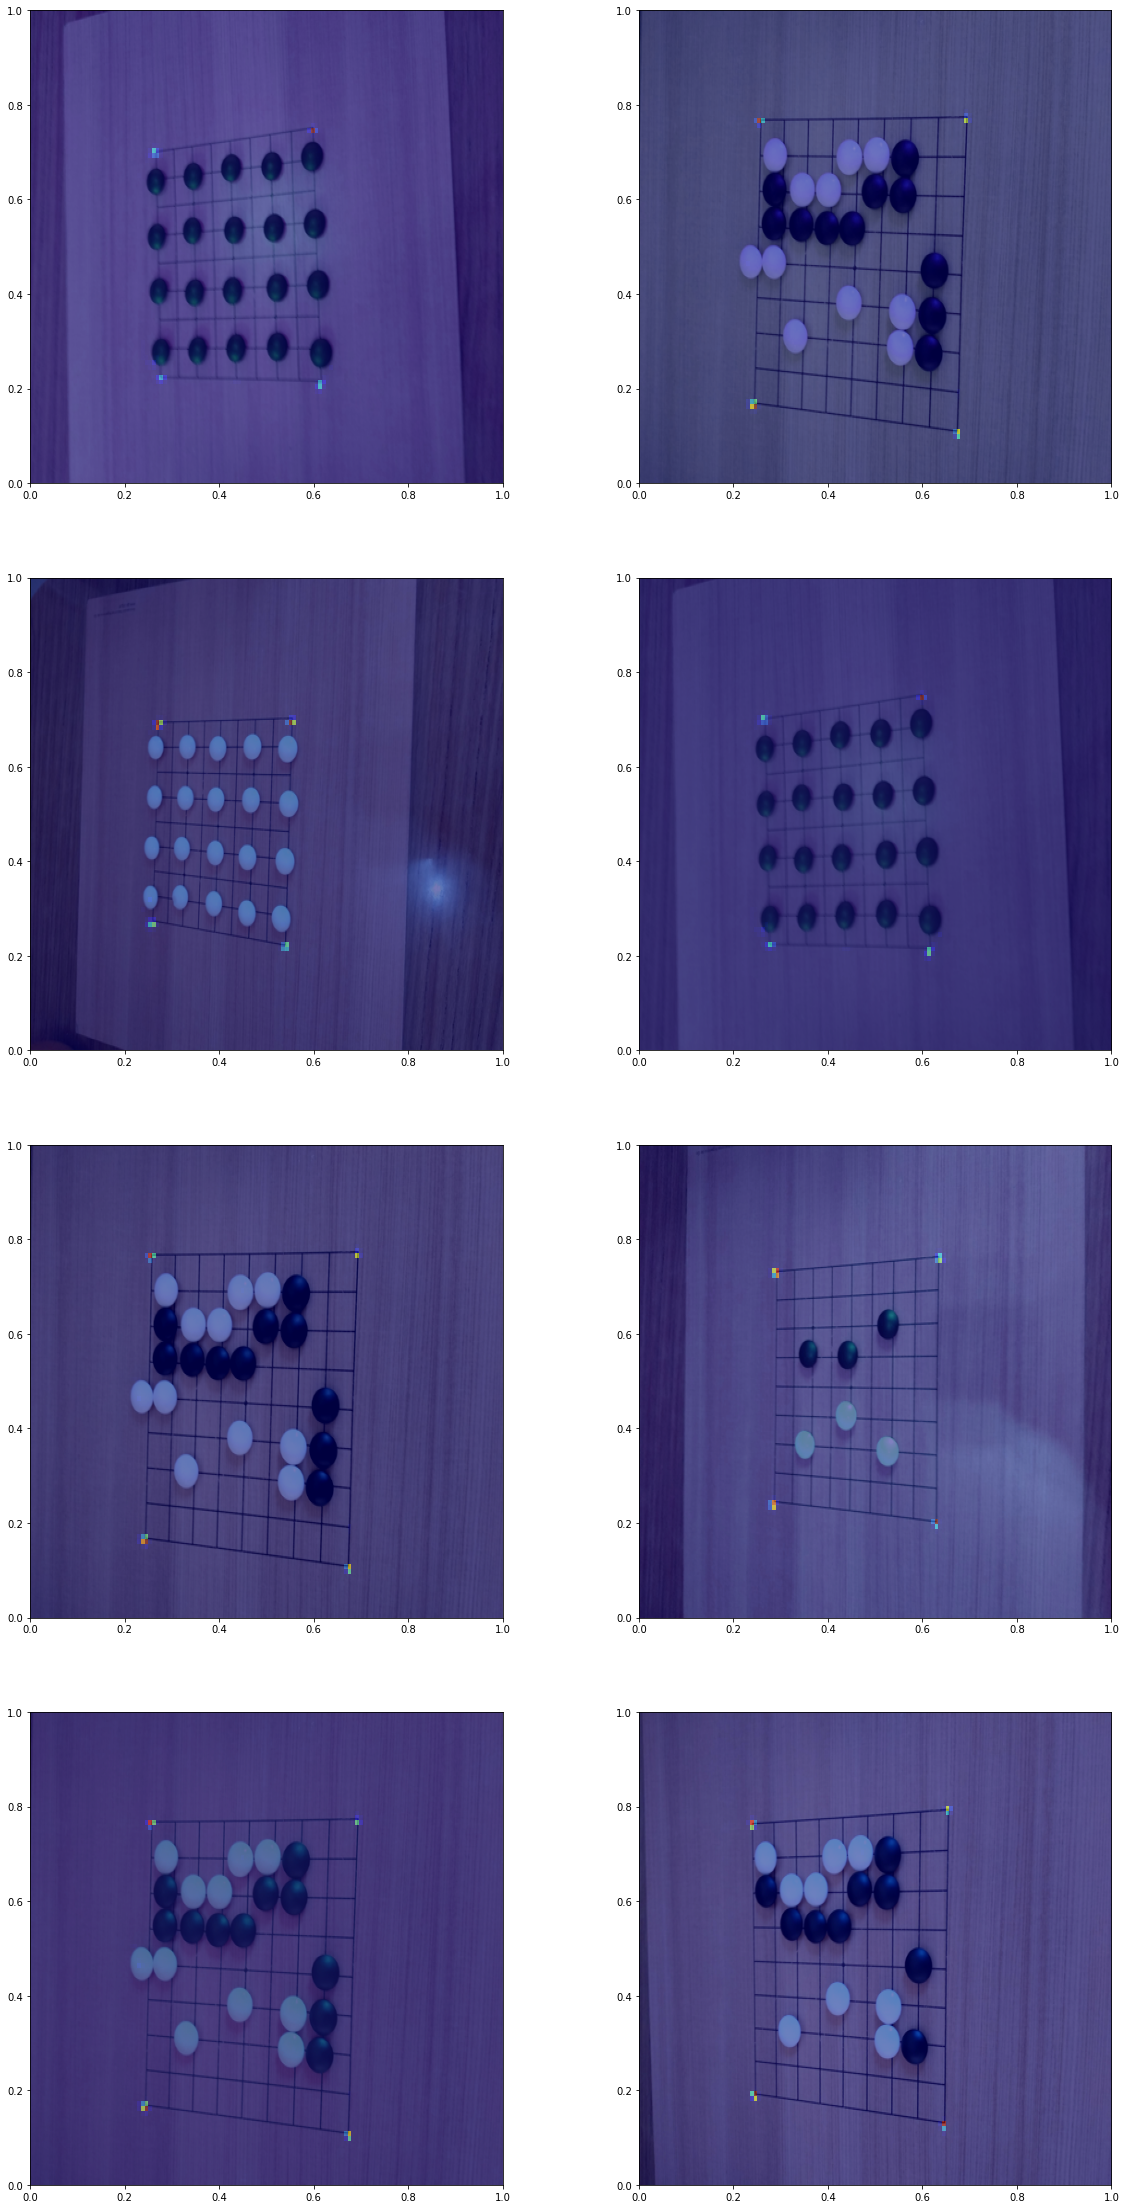

In [10]:
extent = (0, 1, 0, 1)
plt.figure(figsize=(20,40))
for i in range(8):
    plt.subplot(4, 2, i+1)
    index = random.randrange(len(test))
    img, _, _ = test[index]
    pred = unet(img.unsqueeze(0).cuda())
    plt.imshow(img.permute(1,2,0), extent = extent)
    plt.imshow(pred[0].detach().cpu().squeeze(), cmap='jet', extent = extent, alpha=0.5)
plt.show()

## Detect vertex position

### Class

In [0]:
class VertexDetector():
    def __init__(self, unet_model):
        self.unet_model = unet_model.eval()
        self.kmeans = KMeans(n_clusters=4,
                             n_init=5,
                             precompute_distances=True,
                             algorithm='elkan')

    def __call__(self, image):
        segmentation = self.unet_model.vertex_prob(image)
        segmentation[segmentation < 0.01] = 0.0
        segmentation = coo_matrix( segmentation )
        x = np.stack([segmentation.col, segmentation.row]).transpose()
        w = segmentation.data

        km_model = self.kmeans.fit(x, sample_weight=w)
        vertexs = km_model.cluster_centers_ * 4
        vertexs = self.order_vertexs(vertexs)
        return vertexs, segmentation.toarray()

    def order_vertexs(self, vertexs):
        last_prod = 0
        for i in range(len(vertexs)):
            prev = vertexs[(i-1)%4] - vertexs[i]
            post = vertexs[(i+1)%4] - vertexs[i]
            cross_prod = np.cross(post, prev)
            if cross_prod * last_prod < 0:
                vertexs[i], vertexs[(i+1)%4] = vertexs[(i+1)%4].copy(), vertexs[i].copy()
                i += 1
            else:
                last_prod = cross_prod
        return vertexs

vertex_detector = VertexDetector(unet.cpu())

### Test

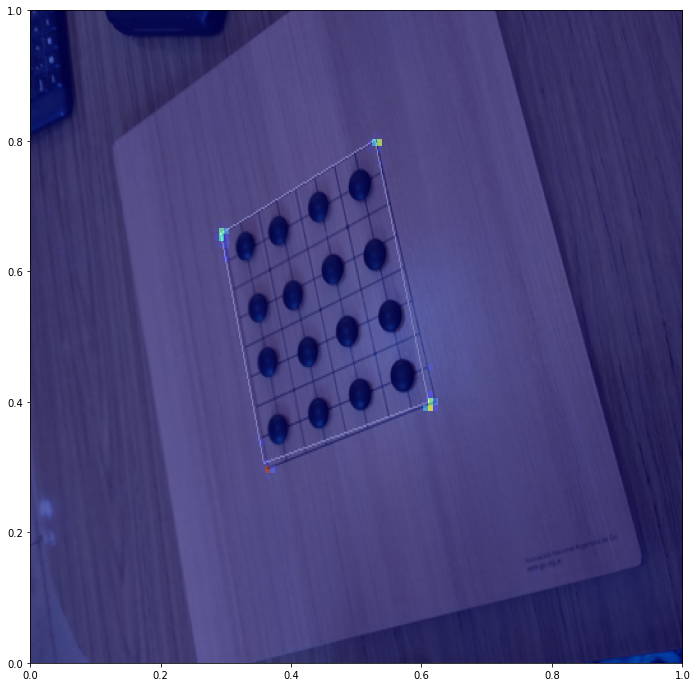

In [12]:
fname = dataset.filename[13]
img = dataset.image[fname].copy()
true_vertex = dataset.vertex[fname]

pred_vertex, segmentation = vertex_detector(img)
draw = ImageDraw.Draw(img)
draw.polygon([(pred_vertex[i][0], pred_vertex[i][1]) for i in range(4)])
#draw.polygon([(true_vertex[i][0], true_vertex[i][1]) for i in range(4)])
del draw

plt.figure(figsize=(16,12))
plt.imshow(img, extent = extent)
plt.imshow(segmentation, cmap='jet', extent = extent, alpha=0.5)

## Board extractor

In [0]:
class BoardExtractor():
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.border = 1 / 9

    def __call__(self, img, vertexs):
        board = Image.new('RGB', (self.width, self.height))
        board_pix = board.load()
        img_pix = img.load()
        for i in range(self.width):
            for j in range(self.height):
                u = ((1.0 + self.border) * i / self.width) - self.border / 2
                v = ((1.0 + self.border) * j / self.height) - self.border / 2
                x = v * (u * vertexs[0] + (1-u) * vertexs[1]) + (1-v) * (u * vertexs[3] + (1-u) * vertexs[2])
                x[0], x[1] = np.clip(x[0], 0, img.size[0]-1), np.clip(x[1], 0, img.size[1]-1)
                board_pix[i,j] = img_pix[int(x[0]), int(x[1])]
        return board
                
board_extractor = BoardExtractor(144, 144)

IMG_20200216_084328.jpg
IMG_20200216_084314.jpg
IMG_20200216_083555.jpg
IMG_20200216_083754.jpg
IMG_20200216_085234.jpg
IMG_20200216_084457.jpg
IMG_20200216_083737.jpg
IMG_20200216_084620.jpg
IMG_20200216_084950.jpg


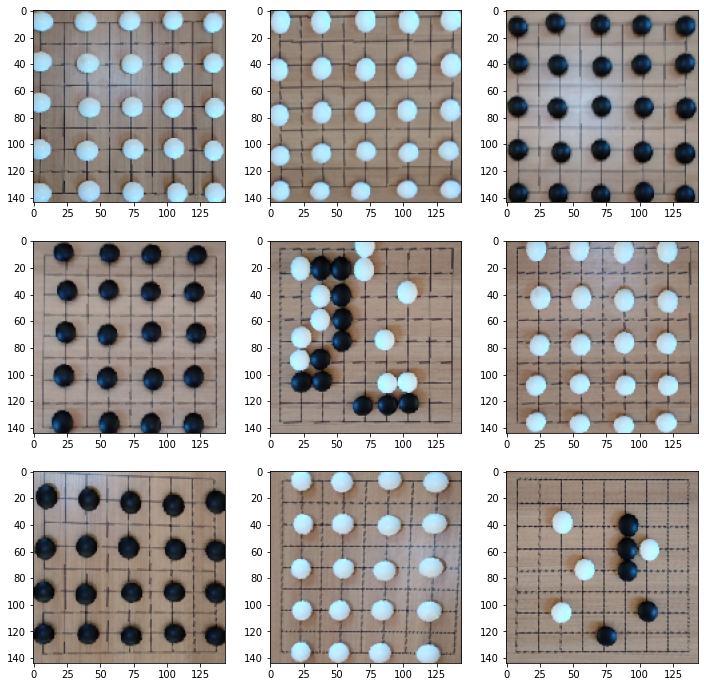

In [14]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    index = random.randrange(len(dataset))
    img = dataset.image[dataset.filename[index]]
    print(dataset.filename[index])
    vert, _ = vertex_detector(img)
    board = board_extractor(img, vert)
    plt.imshow(board)
plt.show()

# Board interpreter

### Dataset

In [0]:
class BoardDataset(Dataset):
    def __init__(self, go_dataset, vertex_detector, board_extractor):
        super(Dataset, self).__init__()
        self.dataset = go_dataset
        self.vertex_detector = vertex_detector
        self.board_extractor = board_extractor
        self.to_tensor = transforms.ToTensor()
        self.cache = {}

    def __len__(self):
      return 2 * len(self.dataset)

    def __getitem__(self, i):
        fname = self.dataset.filename[int(i / 2)]
        try:
            return self.cache[fname]
        except:
            img = self.dataset.image[fname]
            correct = i % 2 == 0
            if correct:
                vert, _ = self.vertex_detector(img)
            else:
                vert = np.random.randint(0, 512, size=(4, 2))
            img = self.board_extractor(img, vert)
            img = self.to_tensor(img)
            pos = self.dataset.position[fname]
            self.cache[fname] = (img, pos, tr.Tensor([correct]))
            return img, pos, tr.Tensor([correct])

    
board_dataset = BoardDataset(dataset, vertex_detector, board_extractor)

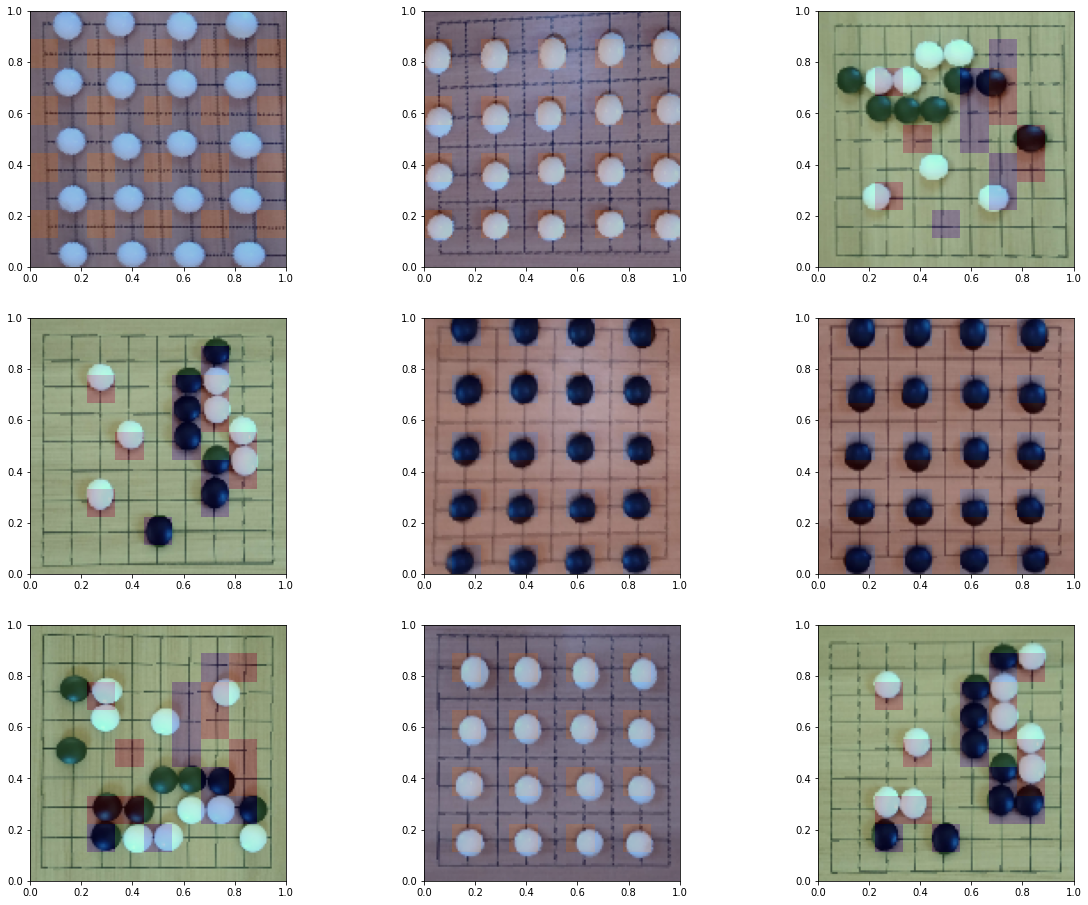

In [16]:
extent = (0, 1, 0, 1)
plt.figure(figsize=(20,16))
for i in range(9):
    plt.subplot(3, 3, i+1)
    index = random.randrange(len(dataset)) * 2 
    plt.imshow(board_dataset[index][0].permute(1,2,0), extent=extent)
    plt.imshow(board_dataset[index][1], cmap='jet', extent=extent, alpha=0.2)
plt.show()

### Anisotropic Loss function

In [0]:
class AMSELoss():
    def mse_loss(self, a, b):
        return (a - b).pow(2).mean(1).mean(1)

    def __call__(self, pred, label):
        losses = []
        losses.append(self.mse_loss(label, pred))
        losses.append(self.mse_loss(label, pred.flip(1)))
        losses.append(self.mse_loss(label, pred.flip(2)))
        pred = pred.permute(0, 2, 1)
        losses.append(self.mse_loss(label, pred))
        losses.append(self.mse_loss(label, pred.flip(1)))
        losses.append(self.mse_loss(label, pred.flip(2)))
        return tr.stack(losses).min(0)[0]


### CNN interpreter

In [0]:
def conv_block(in_dim, out_dim):
    return nn.Sequential(nn.Conv2d(in_dim, out_dim, kernel_size=[3,3], padding=[1,1]),
                         nn.ELU(),
                         nn.BatchNorm2d(out_dim))

    

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_blocks = nn.Sequential(conv_block(3, 8),
                                         nn.AvgPool2d(2),
                                         conv_block(8, 16),
                                         nn.AvgPool2d(2),
                                         conv_block(16, 32),
                                         nn.AvgPool2d(2),
                                         conv_block(32, 64),
                                         nn.AvgPool2d(2),
                                         conv_block(64, 64))
        
        self.board_interpreter = nn.Sequential(nn.Conv2d(64, 1, kernel_size=[1,1]),
                                               nn.Tanh())
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.board_checker = nn.Sequential(nn.Linear(64, 32),
                                           nn.ELU(),
                                           nn.BatchNorm1d(32),
                                           nn.Linear(32, 8),
                                           nn.ELU(),
                                           nn.BatchNorm1d(8),
                                           nn.Linear(8, 1),
                                           nn.Sigmoid())

    def forward(self, x):
        x = self.conv_blocks(x)
        board = self.board_interpreter(x).squeeze()
        x = self.global_pooling(x)
        is_correct = self.board_checker(x.view(-1, 64)).squeeze()
        return board, is_correct
      
    def load(self, fname):
        self.load_state_dict(tr.load(fname, map_location=lambda storage, loc: storage))

    def save(self, fname):
        tr.save(self.state_dict(), fname)

### Training

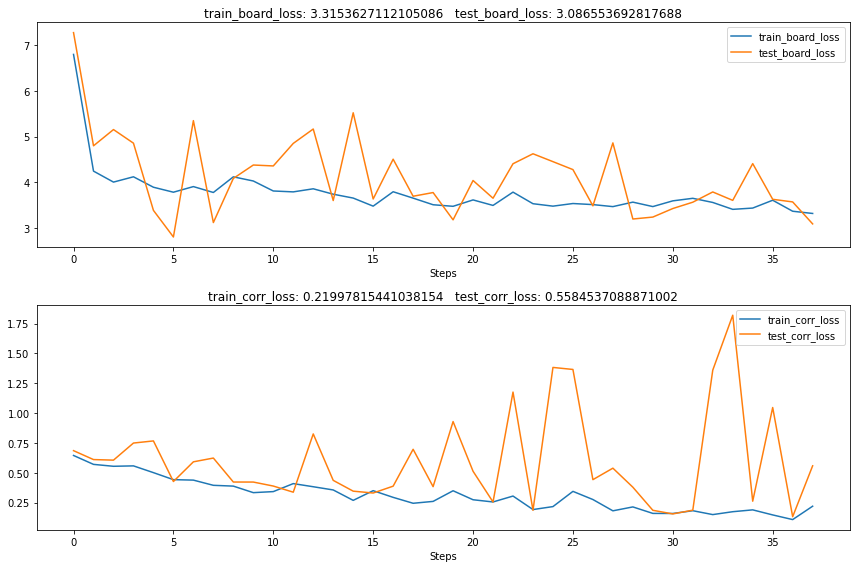

In [0]:
cnn = CNN().cuda()

train, test = random_split(board_dataset, (len(board_dataset)-16, 16))

if RETRAIN_CNN:
    hist = hl.History()
    canvas = hl.Canvas()

    train_loader = DataLoader(train, batch_size=8, shuffle=True,
                            num_workers=4, pin_memory=True)

    test_loader = DataLoader(test, batch_size=8, shuffle=True,
                            num_workers=4, pin_memory=True)

    board_loss_func = AMSELoss()
    corr_loss_func = nn.BCELoss()
    optimizer = tr.optim.Adam(cnn.parameters())
            
    epoch = 0
    best_test_loss = float('inf')
    epochs_without_improvement = 0
    while epochs_without_improvement < 50:
        cnn.eval()
        board_test_loss = 0
        corr_test_loss = 0
        for img, pos, ok in test_loader:
            img, pos, ok = img.cuda(), pos.cuda(), ok.cuda()

            pred_board, pred_ok = cnn(img)
            
            board_loss = board_loss_func(pred_board, pos)
            board_loss = (board_loss * ok).sum()
            corr_loss = corr_loss_func(pred_ok, ok.squeeze())
            board_test_loss += board_loss.data.item() / len(test_loader)
            corr_test_loss += corr_loss.data.item() / len(test_loader)


        cnn.train()
        board_train_loss = 0
        corr_train_loss = 0
        for img, pos, ok in train_loader:
            img, pos, ok = img.cuda(), pos.cuda(), ok.cuda()

            pred_board, pred_ok = cnn(img)
            
            optimizer.zero_grad()
            board_loss = board_loss_func(pred_board, pos)
            board_loss = (board_loss * ok).sum()
            corr_loss = corr_loss_func(pred_ok, ok.squeeze())
            loss = board_loss + 0.1 * corr_loss
            loss.backward()
            optimizer.step()

            board_train_loss += board_loss.data.item() / len(train_loader)
            corr_train_loss += corr_loss.data.item() / len(train_loader)

        if board_test_loss < best_test_loss:
            cnn.save("models/cnn_interpreter.pmt")
            best_test_loss = board_test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        hist.log(epoch, train_board_loss=board_train_loss, train_corr_loss=corr_train_loss)
        hist.log(epoch, test_board_loss=board_test_loss, test_corr_loss=corr_test_loss)

        with canvas:
            canvas.draw_plot([hist["train_board_loss"], hist["test_board_loss"]])
            canvas.draw_plot([hist["train_corr_loss"], hist["test_corr_loss"]])
        epoch += 1

    hist.summary()
cnn.load("models/cnn_interpreter.pmt")

### Test

In [0]:
plt.figure(figsize=(16,16))
cnn.eval()
for i in range(16):
    plt.subplot(4, 4, i+1)
    img, _, _ = test[i]
    pred, ok = cnn(img.unsqueeze(0).cuda())
    plt.imshow(img.permute(1,2,0), extent = extent)
    if (ok > 0.5).item():
        plt.imshow(pred.detach().cpu().squeeze(),
                   norm = Normalize(vmin = -1, vmax = 1),
                   cmap='bwr',
                   extent = extent,
                   alpha=0.5)
        plt.title('Correct')
    else:
        plt.title('Incorrect')
plt.show()